In [1]:
import numpy as np
import librosa
import librosa.display
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [2]:
SR = 22050
DURATION = 1
N_BINS_CQT = 60
BINS_PER_OCTAVE_CQT = 12
HOP_LENGTH_CQT = 512

In [3]:
ds = glob('mswc_microset/mswc_microset/*/clips/*/*.opus')

In [4]:
file_num_1, file_num_2 = 5, 10 # Choose two different file indices from your dataset

file1_path = ds[file_num_1]
file2_path = ds[file_num_2]

print(f"Processing File 1: {file1_path}")
print(f"Processing File 2: {file2_path}")

y1, sr1 = librosa.load(file1_path, sr=SR, duration=DURATION)
y2, sr2 = librosa.load(file2_path, sr=SR, duration=DURATION)

if len(y1) < SR * DURATION:
    y1 = np.pad(y1, (0, max(0, int(SR * DURATION) - len(y1))))
if len(y2) < SR * DURATION:
    y2 = np.pad(y2, (0, max(0, int(SR * DURATION) - len(y2))))

Processing File 1: mswc_microset/mswc_microset\en\clips\backward\common_voice_en_18854341.opus
Processing File 2: mswc_microset/mswc_microset\en\clips\backward\common_voice_en_19814783.opus


In [5]:
C1 = librosa.cqt(y=y1, sr=sr1, n_bins=N_BINS_CQT, bins_per_octave=BINS_PER_OCTAVE_CQT, hop_length=HOP_LENGTH_CQT)
C_db1 = librosa.amplitude_to_db(np.abs(C1), ref=np.max)

C2 = librosa.cqt(y=y2, sr=sr2, n_bins=N_BINS_CQT, bins_per_octave=BINS_PER_OCTAVE_CQT, hop_length=HOP_LENGTH_CQT)
C_db2 = librosa.amplitude_to_db(np.abs(C2), ref=np.max)

n_bins_cqt, n_frames1_cqt = C_db1.shape
_, n_frames2_cqt = C_db2.shape

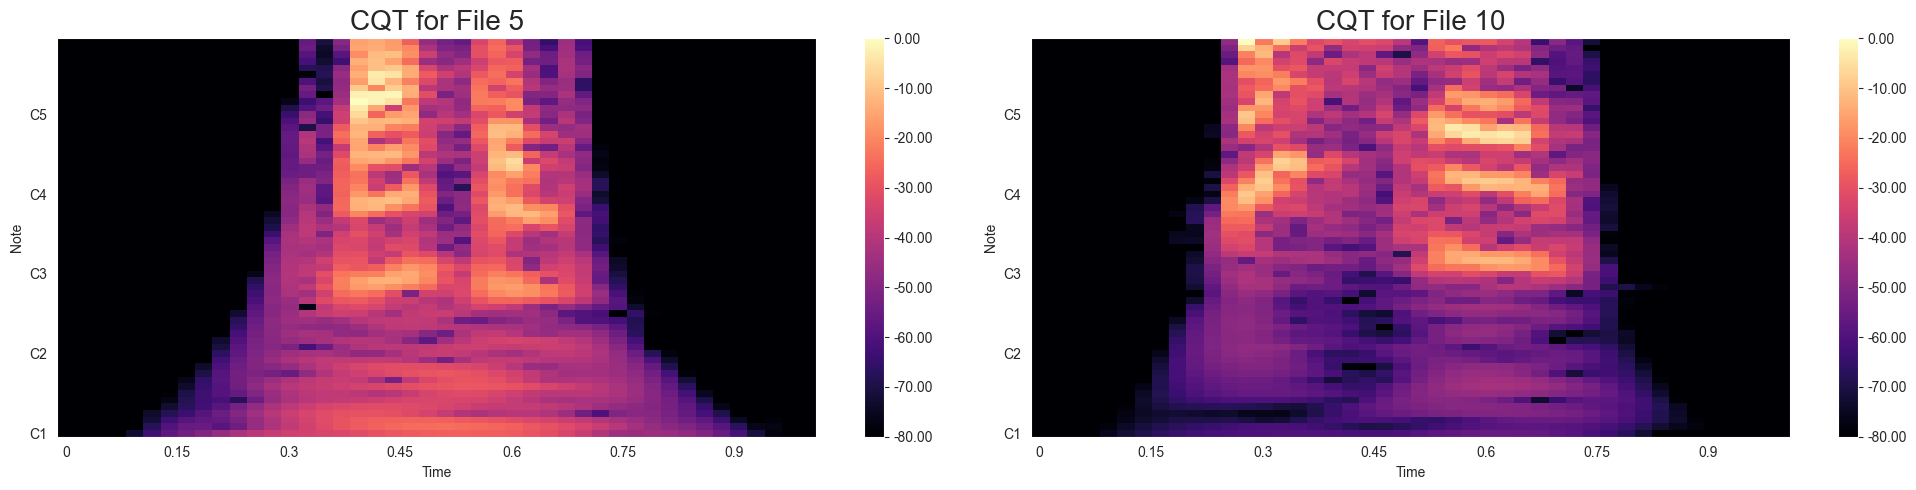

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))  # 1 row, 2 columns

# First plot
img1 = librosa.display.specshow(C_db1, x_axis='time', y_axis='cqt_note', ax=axs[0])
axs[0].set_title(f'CQT for File {file_num_1}', fontsize=20)
fig.colorbar(img1, ax=axs[0], format='%0.2f')

# Second plot
img2 = librosa.display.specshow(C_db2, x_axis='time', y_axis='cqt_note', ax=axs[1])
axs[1].set_title(f'CQT for File {file_num_2}', fontsize=20)
fig.colorbar(img2, ax=axs[1], format='%0.2f')

plt.tight_layout()
plt.show()

In [7]:
max_frames_cqt = max(n_frames1_cqt, n_frames2_cqt)
C_db1_padded = np.pad(C_db1, ((0, 0), (0, max_frames_cqt - n_frames1_cqt)), mode='constant')
C_db2_padded = np.pad(C_db2, ((0, 0), (0, max_frames_cqt - n_frames2_cqt)), mode='constant')

Saving CQT animation as GIF...
CQT animation saved.


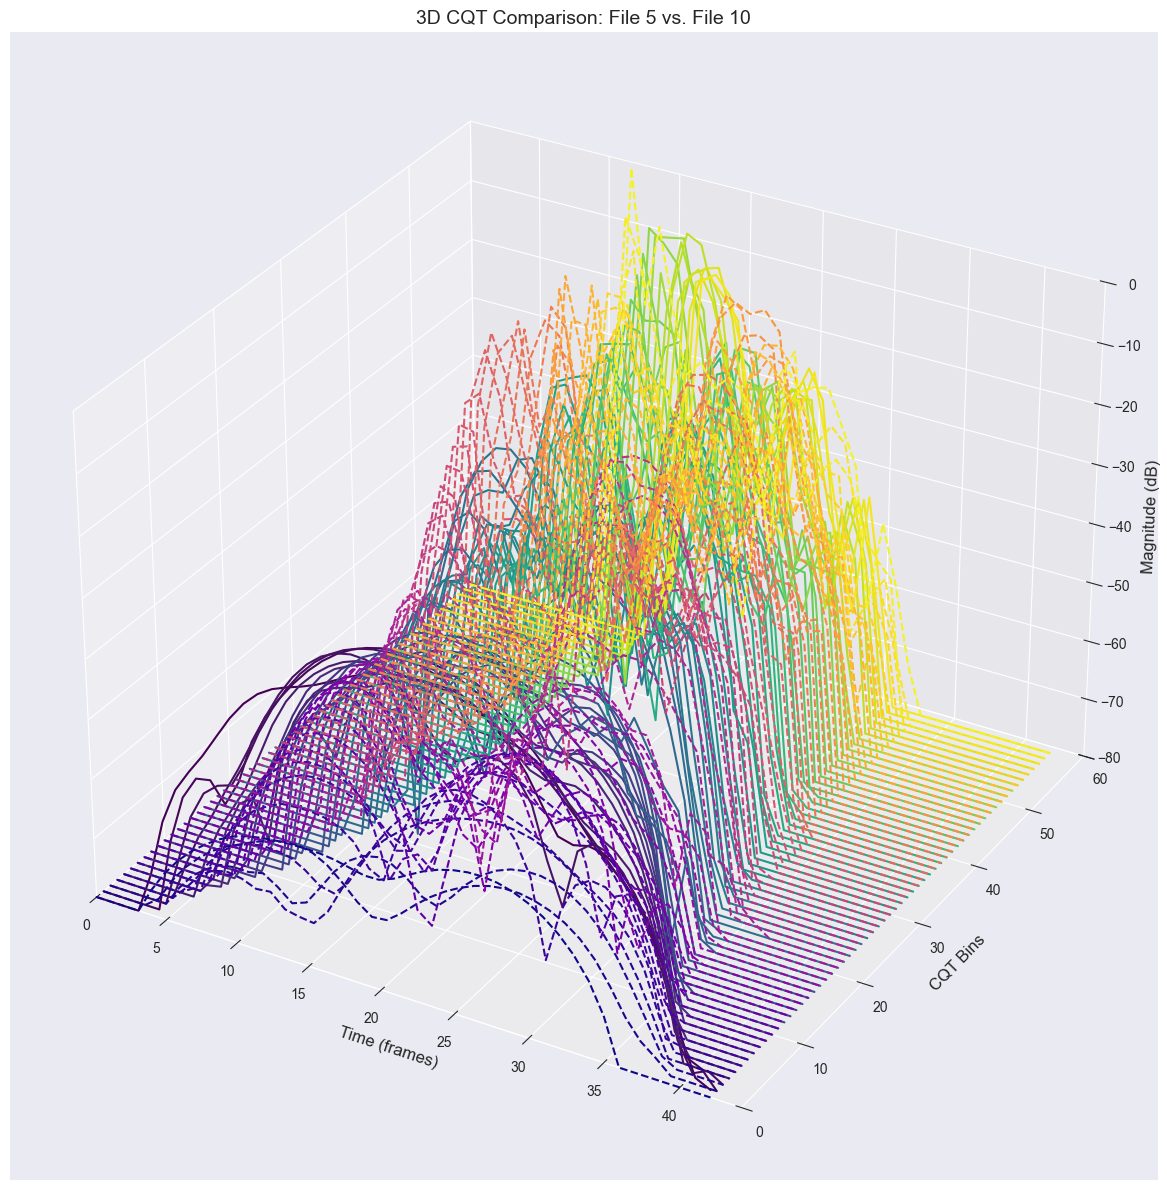

In [8]:
time_cqt = np.arange(max_frames_cqt)
cqt_bins = np.arange(n_bins_cqt)

fig_cqt = plt.figure(figsize=(18, 12)) # Adjusted figure size for better visibility
ax_cqt = fig_cqt.add_subplot(111, projection='3d')

ax_cqt.set_xlabel('Time (frames)', fontsize=12)
ax_cqt.set_ylabel('CQT Bins', fontsize=12)
ax_cqt.set_zlabel('Magnitude (dB)', fontsize=12)
ax_cqt.set_title(f'3D CQT Comparison: File {file_num_1} vs. File {file_num_2}', fontsize=14)

# Set axis limits
ax_cqt.set_xlim(0, max_frames_cqt)
ax_cqt.set_ylim(0, n_bins_cqt)
ax_cqt.set_zlim(min(C_db1_padded.min(), C_db2_padded.min()), max(C_db1_padded.max(), C_db2_padded.max()))

# Create empty lines for each CQT bin for both files
lines1_cqt = [ax_cqt.plot([], [], [], lw=1.5, color=plt.cm.viridis(i / n_bins_cqt),
                           label=f'CQT Bin {i+1} (File {file_num_1})')[0] for i in cqt_bins]
lines2_cqt = [ax_cqt.plot([], [], [], lw=1.5, linestyle='--', color=plt.cm.plasma(i / n_bins_cqt),
                           label=f'CQT Bin {i+1} (File {file_num_2})')[0] for i in cqt_bins]

# Add legend (only a subset for clarity, or consider a separate legend for each file)
# For simplicity, we'll add a general legend. If many bins, this can get crowded.
# You might want to remove this or make it more selective for real use.
# ax_cqt.legend(loc='upper right', bbox_to_anchor=(1.2, 1), fontsize=8)

# Animation function for CQT
def update_cqt(frame):
    for i, (line1, line2) in enumerate(zip(lines1_cqt, lines2_cqt)):
        line1.set_data(time_cqt[:frame], np.ones(frame) * i)
        line1.set_3d_properties(C_db1_padded[i, :frame])
        line2.set_data(time_cqt[:frame], np.ones(frame) * i)
        line2.set_3d_properties(C_db2_padded[i, :frame])
    return lines1_cqt + lines2_cqt

# Create and run the animation
# Reduce frames for faster GIF generation if needed (e.g., frames=range(0, max_frames_cqt, 5))
ani_cqt = FuncAnimation(fig_cqt, update_cqt, frames=max_frames_cqt, interval=50, blit=False)

# Save as GIF (requires `pillow`)
print("Saving CQT animation as GIF...")
ani_cqt.save('3d_cqt_comparison_animation.gif', writer='pillow', fps=15, dpi=100)
print("CQT animation saved.")

# Alternatively, save as MP4 (requires `ffmpeg`)
# ani_cqt.save('bilingual_cqt_comparison.mp4', writer='ffmpeg', fps=15)

plt.tight_layout()
plt.show()

Saving CQT animation as GIF...
CQT animation saved.


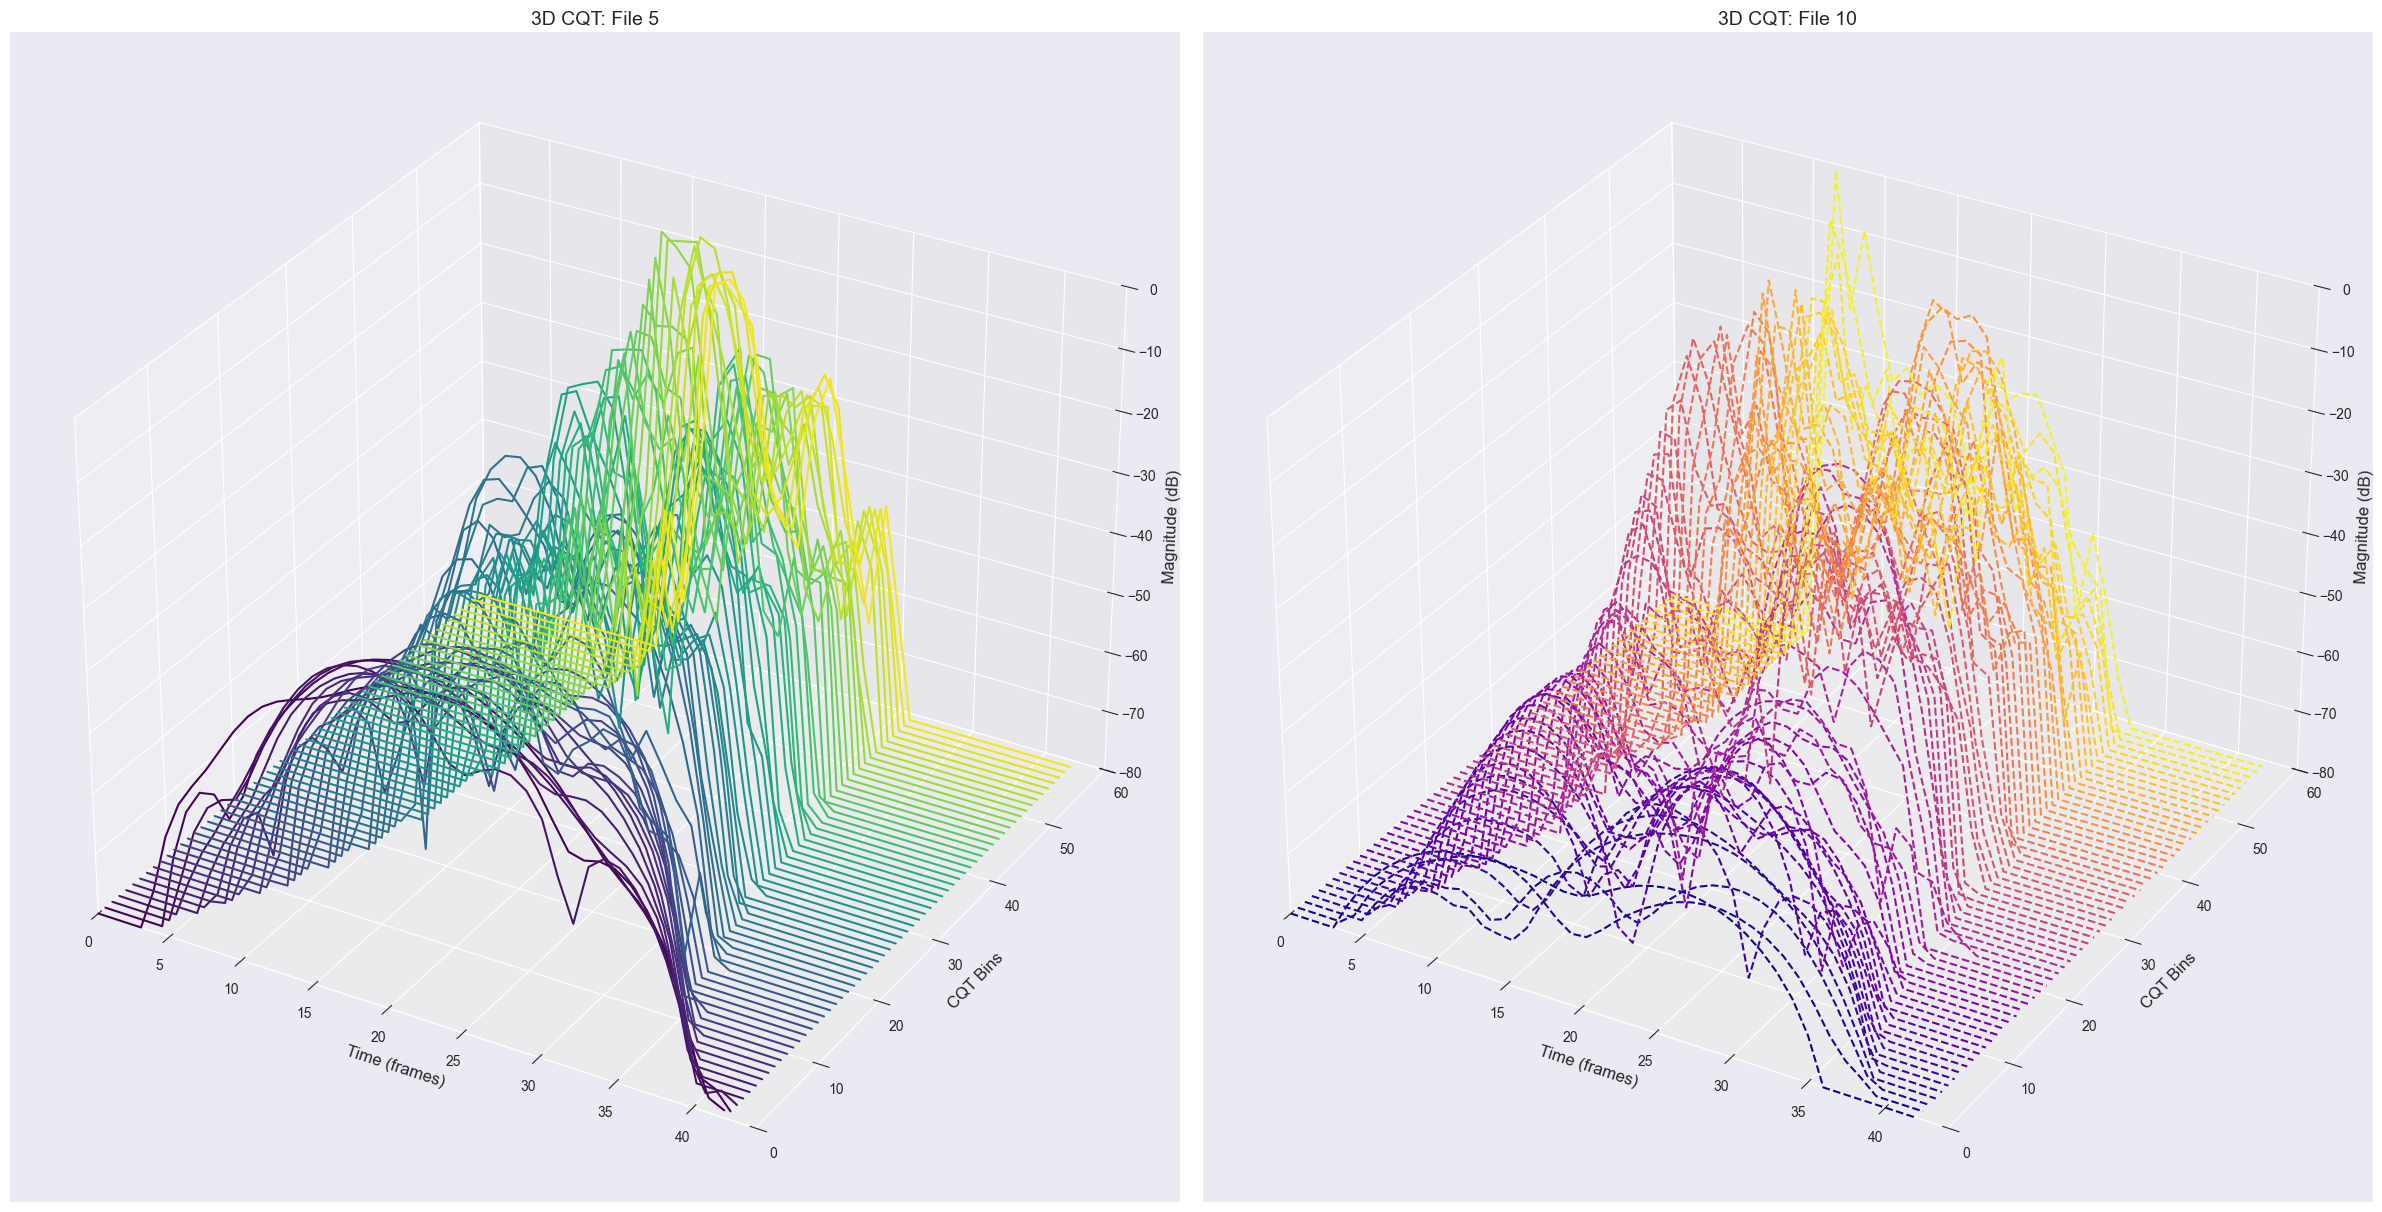

In [9]:
time_cqt = np.arange(max_frames_cqt)
cqt_bins = np.arange(n_bins_cqt)

fig_cqt = plt.figure(figsize=(24, 12))  # Wider figure for two plots side by side

# First 3D subplot for File 1
ax1 = fig_cqt.add_subplot(121, projection='3d')
ax1.set_xlabel('Time (frames)', fontsize=12)
ax1.set_ylabel('CQT Bins', fontsize=12)
ax1.set_zlabel('Magnitude (dB)', fontsize=12)
ax1.set_title(f'3D CQT: File {file_num_1}', fontsize=14)
ax1.set_xlim(0, max_frames_cqt)
ax1.set_ylim(0, n_bins_cqt)
ax1.set_zlim(C_db1_padded.min(), C_db1_padded.max())

lines1_cqt = [ax1.plot([], [], [], lw=1.5, color=plt.cm.viridis(i / n_bins_cqt))[0]
              for i in cqt_bins]

# Second 3D subplot for File 2
ax2 = fig_cqt.add_subplot(122, projection='3d')
ax2.set_xlabel('Time (frames)', fontsize=12)
ax2.set_ylabel('CQT Bins', fontsize=12)
ax2.set_zlabel('Magnitude (dB)', fontsize=12)
ax2.set_title(f'3D CQT: File {file_num_2}', fontsize=14)
ax2.set_xlim(0, max_frames_cqt)
ax2.set_ylim(0, n_bins_cqt)
ax2.set_zlim(C_db2_padded.min(), C_db2_padded.max())

lines2_cqt = [ax2.plot([], [], [], lw=1.5, linestyle='--', color=plt.cm.plasma(i / n_bins_cqt))[0]
              for i in cqt_bins]

# Animation function updates both subplots
def update_cqt(frame):
    for i, line in enumerate(lines1_cqt):
        line.set_data(time_cqt[:frame], np.ones(frame) * i)
        line.set_3d_properties(C_db1_padded[i, :frame])
    for i, line in enumerate(lines2_cqt):
        line.set_data(time_cqt[:frame], np.ones(frame) * i)
        line.set_3d_properties(C_db2_padded[i, :frame])
    return lines1_cqt + lines2_cqt

ani_cqt = FuncAnimation(fig_cqt, update_cqt, frames=max_frames_cqt,
                        interval=50, blit=False)

print("Saving CQT animation as GIF...")
ani_cqt.save('3d_cqt_side_by_side_animation.gif', writer='pillow', fps=15, dpi=100)
print("CQT animation saved.")

plt.tight_layout()
plt.show()